This notebook display the Gene DB for Prochlorococcus

# Includes and setup

In [1]:
import os
import json
from dotenv import load_dotenv
from openai import OpenAI
import anthropic
import google.generativeai
import gradio as gr
from IPython.display import Markdown, display, update_display

In [2]:
import pandas as pd
import numpy as np
import re

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from prompts import * 


In [5]:
# Load environment variables in a file called .env
# Print the key prefixes to help with any debugging

load_dotenv()
openai_api_key = os.getenv('OPENAI_API_KEY')
anthropic_api_key = os.getenv('ANTHROPIC_API_KEY')
google_api_key = os.getenv('GOOGLE_API_KEY')

if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set")
    
if anthropic_api_key:
    print(f"Anthropic API Key exists and begins {anthropic_api_key[:7]}")
else:
    print("Anthropic API Key not set")

if google_api_key:
    print(f"Google API Key exists and begins {google_api_key[:8]}")
else:
    print("Google API Key not set")

OpenAI API Key exists and begins sk-proj-
Anthropic API Key exists and begins sk-ant-
Google API Key exists and begins AIzaSyCF


In [6]:
anthropic_client = anthropic.Anthropic(
    # defaults to os.environ.get("ANTHROPIC_API_KEY")
    #api_key="my_api_key",
)
MODEL = "claude-3-5-sonnet-20241022"
max_tokens=4096
temperature=0

# Load list of MED4 genes

In [7]:
med4_genome_dpath = '../genomes/MED4'
#os.listdir(med4_genome_dpath)

In [8]:
gff_named_df = pd.read_csv(os.path.join(med4_genome_dpath, 'MED4_named_genes_NCBI.csv'))
gff_named_df

,gene_name,gene,locus_tag,product,protein_id
0,"dnaN , TX50_RS00020",dnaN,TX50_RS00020,DNA polymerase III subunit beta,WP_011131639.1
1,"purL , TX50_RS00030",purL,TX50_RS00030,phosphoribosylformylglycinamidine synthase sub...,WP_011131641.1
2,"purF , TX50_RS00035",purF,TX50_RS00035,amidophosphoribosyltransferase,WP_011131642.1
3,"queG , TX50_RS00050",queG,TX50_RS00050,tRNA epoxyqueuosine(34) reductase QueG,WP_011131645.1
4,"nusB , TX50_RS00060",nusB,TX50_RS00060,transcription antitermination factor NusB,WP_036930720.1
...,...,...,...,...,...
498,"dnaK , TX50_RS09095",dnaK,TX50_RS09095,molecular chaperone DnaK,WP_011133331.1
499,"rpsF , TX50_RS09105",rpsF,TX50_RS09105,30S ribosomal protein S6,WP_011133333.1
500,"mraY , TX50_RS09125",mraY,TX50_RS09125,phospho-N-acetylmuramoyl-pentapeptide-transferase,WP_036930713.1
501,"uvrA , TX50_RS09140",uvrA,TX50_RS09140,excinuclease ABC subunit UvrA,WP_011133339.1


# Load anthropic batch results

In [9]:
batch_result_fpath = os.path.join('batch results', 'anthropic_batch_single_prompt_26012025_results.jsonl')

In [10]:
import jsonlines

In [11]:
with jsonlines.open(batch_result_fpath) as reader:
    batch_results_jsonl = [obj for obj in reader]

In [12]:
def _get_gene_name_from_custom_id(id):
    '''
         extract and return the gene_name from the custom id
         example : 'batch-id-dnaN--TX50_RS00020' --> dnaN, TX50_RS00020
    '''
    #return id.replace('batch-id-', '').replace('--', ' , ')
    id1 = id.replace('batch-id-', '')
    return (id1.split('-')[0])
    #return id.replace('batch-id-', '').replace('--', ' , ')
    

In [13]:
message_status = [m['result']['type'] for m in batch_results_jsonl]
#message_status


In [14]:
# check the status of the batch jobs
from collections import Counter
Counter(message_status)

Counter({'succeeded': 503})

In [15]:
gff_named_df.loc[gff_named_df.gene.isin([_get_gene_name_from_custom_id(batch_results_jsonl[0]['custom_id'])])]

,gene_name,gene,locus_tag,product,protein_id
0,"dnaN , TX50_RS00020",dnaN,TX50_RS00020,DNA polymerase III subunit beta,WP_011131639.1


In [16]:
batch_result_dict = {
    _get_gene_name_from_custom_id(m['custom_id']) :  m['result']['message']['content'][0]['text']
    for m in batch_results_jsonl            
}

In [17]:
batch_results_jsonl[0].keys()

dict_keys(['custom_id', 'result'])

In [18]:
batch_results_jsonl[0]['custom_id']

'batch-id-dnaN--TX50_RS00020'

In [19]:
# print(batch_results_jsonl[0]['result']['message']['content'][0]['text'])

# Parse the replies into multiple elements

## example

In [20]:
gene = 'dnaN'

In [21]:
text = '<literature_review>\n' + batch_result_dict[gene]

In [22]:
def parse_claude_message(message):
    tags = {}
    for tag, content in re.findall(r'<(\w+)>(.*?)</\1>', message, re.DOTALL):
        tags[tag] = content.strip()
    return tags

In [23]:
def get_left_text(text, parsed_text):
    left_text = text
    for i in parsed_text: 
        left_text = left_text.replace(parsed_text[i], '')
    return (left_text)
    

In [24]:
def get_inner_tags(text):
    parsed_text = parse_claude_message(text)
    left_text = text
    for i in parsed_text: 
        left_text = left_text.replace(parsed_text[i], '')
    return (left_text)
    

In [25]:

def parse_database_batch_message(gene):
    message = '<literature_review>\n' + batch_result_dict[gene]
    # remove <conservation> tags
    message = message.replace('<conservation>', 'Conservation: ')
    message = message.replace('      Conservation:', '  Conservation:')
    message = message.replace('</conservation>', '')
    if '</literature_review>' not in message:
        message = message.replace('<database_entry>', '</literature_review>\n\n<database_entry>')
        
    database_section_names = ['primary_function', 'physiological_contribution', 'stress_responses', 'uptake_exudation', 
        'phylogenetic_persistence', 'coculture_role', 'references']
    parsed_text = parse_claude_message(message)
    
    #assert set(parsed_text.keys()) == {'literature_review', 'database_entry'}, f'Wrong top keys: {parsed_text.keys()}, gene: {gene}'
    assert 'database_entry' in parsed_text.keys() , f'Missing database_entry. Wrong top keys: {parsed_text.keys()}, gene: {gene}'
    if 'literature_review' in parsed_text.keys():
        literature_review = parsed_text['literature_review']
    else:
        literature_review = ''
        print(f'Missing literature_review ({gene})')
        
    database_entry = parsed_text['database_entry']
    parsed_database_entry = parse_claude_message(database_entry)
    assert set(list(parsed_database_entry.keys())) == set(database_section_names), f'Wrong database section names: {parsed_database_entry.keys()}, gene: {gene}' 
    for i in ['stress_responses', 'uptake_exudation', 'references']:
        parsed_database_entry[i] = parse_claude_message(parsed_database_entry[i])
    return literature_review, parsed_database_entry
    #print(parsed_database_entry)
    # for i in database_sections:
    #     print(i)
    #     print(get_inner_tags(parsed_database_entry[i]))
    
 

In [26]:
literature_review, database_entry = parse_database_batch_message(gene)

In [27]:
def database_section_dict2text(section_dict):
    items_list = [f'* {name}: {text}' for name, text in section_dict.items()]
    return '\n\n'.join(items_list)

def database_section2text(section_name, section_content):
    if isinstance(section_content, dict):
        section_content = database_section_dict2text(section_content)
    section_name = section_name.capitalize()
    return f'\n### {section_name}\n\n{section_content}\n'

In [28]:
def database_entry2text(database_entry):
    title = '# Database Entry\n'
    return title + '\n'.join([database_section2text(section_name, section_content) for section_name, section_content in database_entry.items()])


In [29]:
def literature_review2text(literature_review):
    lines = literature_review.split('\n')
    new_lines = [f'### {line}\n' if line and line[0].isdigit() else line for line in lines]
    title = '# Literature Review\n'
    return title + '\n'.join(new_lines)


In [30]:
display(Markdown(literature_review2text(literature_review)))


# Literature Review
### 1. Key Search Terms and Databases:

- Primary databases: PubMed, Web of Science, NCBI Gene, UniProt
- Search terms: "dnaN Prochlorococcus", "DNA polymerase III beta subunit cyanobacteria", "sliding clamp Prochlorococcus", "WP_011131639.1", "DNA replication Prochlorococcus"

### 2. Literature Overview:

- ~15 directly relevant papers
- Date range: 1998-2023
- Main focus: DNA replication mechanisms in cyanobacteria, sliding clamp function in prokaryotes

### 3. Key Sources:


a) [Robinson et al., 2013] "Structure and mechanism of the β-sliding clamp from E. coli"
- Detailed structural analysis of the β-sliding clamp
- Established conserved mechanism across prokaryotes

b) [Johnson & O'Donnell, 2005] "Cellular DNA Replicases"
- Comprehensive review of DNA polymerase III function
- Describes essential role of β-subunit in processivity

c) [Partensky et al., 1999] "Prochlorococcus: Advantages and Limits of Minimalism"
- Overview of Prochlorococcus genome streamlining
- Discusses conservation of essential DNA replication machinery

### 4. Challenges:

- Limited direct studies on dnaN in Prochlorococcus
- Most information inferred from other bacterial systems
- Few studies on regulation under different conditions

### 5. Research Gaps:

- Limited information on strain-specific variations
- Lack of data on expression changes in coculture
- Unknown stress response patterns

### 6. Initial Observations:

- Highly conserved essential gene
- Critical for DNA replication fidelity
- Part of core genome maintained despite genome streamlining

### 7. Key Themes:

- Essential for cell division
- Highly conserved structure and function
- Part of minimal genome requirements

### 8. Potential Implications:

- May influence growth rate regulation
- Could be involved in stress response
- Potential target for studying cell cycle control

In [31]:
database_entry

{'primary_function': "The dnaN gene encodes the β-sliding clamp subunit of DNA polymerase III, essential for processive DNA replication in Prochlorococcus. It forms a ring-shaped homodimer that encircles DNA and tethers the polymerase to the template, enabling efficient and accurate DNA synthesis [Johnson & O'Donnell, 2005].\n    Conservation: Highly conserved across all prokaryotes, with maintained structure and function across all known Prochlorococcus strains.",
 'physiological_contribution': 'Functions as a central coordinator of DNA replication and repair processes, essential for cell division and genome maintenance. The β-clamp also serves as a platform for other proteins involved in DNA metabolism [Robinson et al., 2013].\n    Conservation: Core function is universally conserved across prokaryotes, including all Prochlorococcus ecotypes.',
 'stress_responses': {'response1': 'Limited direct data available for Prochlorococcus-specific stress responses.\n  Conservation: Information

In [32]:
display(Markdown(database_entry2text(database_entry)))

# Database Entry

### Primary_function

The dnaN gene encodes the β-sliding clamp subunit of DNA polymerase III, essential for processive DNA replication in Prochlorococcus. It forms a ring-shaped homodimer that encircles DNA and tethers the polymerase to the template, enabling efficient and accurate DNA synthesis [Johnson & O'Donnell, 2005].
    Conservation: Highly conserved across all prokaryotes, with maintained structure and function across all known Prochlorococcus strains.


### Physiological_contribution

Functions as a central coordinator of DNA replication and repair processes, essential for cell division and genome maintenance. The β-clamp also serves as a platform for other proteins involved in DNA metabolism [Robinson et al., 2013].
    Conservation: Core function is universally conserved across prokaryotes, including all Prochlorococcus ecotypes.


### Stress_responses

* response1: Limited direct data available for Prochlorococcus-specific stress responses.
  Conservation: Information not available.

* response2: May be involved in DNA damage response pathways based on studies in other bacteria.
  Conservation: Likely conserved but requires experimental validation.


### Uptake_exudation

* uptake: No direct evidence for involvement in uptake processes.
  Conservation: Not applicable.

* exudation: No known role in exudation processes.
  Conservation: Not applicable.


### Phylogenetic_persistence

The dnaN gene is present in all sequenced Prochlorococcus strains and shows high sequence conservation. It represents part of the core genome maintained despite extensive genome streamlining in Prochlorococcus [Partensky et al., 1999].


### Coculture_role

No specific studies available on dnaN expression or function in coculture conditions.
    Conservation: Information not available.


### References

* ref1: Johnson A, O'Donnell M. (2005). Cellular DNA Replicases: Components and Dynamics at the Replication Fork. Annual Review of Biochemistry, 74:283-315.

* ref2: Robinson A, et al. (2013). Structure and mechanism of the β-sliding clamp from E. coli. Nucleic Acids Research, 41(6):3812-3824.

* ref3: Partensky F, et al. (1999). Prochlorococcus: Advantages and Limits of Minimalism. Annual Review of Marine Science, 1:227-252.


# Build Gene DB

In [33]:
def database_section2list(section_name, section_content):
    if isinstance(section_content, dict):
        if section_name == 'uptake_exudation':
            return (section_content.items())
        else:
            return ((section_name, v) for v in section_content.values())
    else: 
        return [(section_name, section_content)]

def get_database_entry_df(gene):
    literature_review, database_entry = parse_database_batch_message(gene)
    content_list = [
        dict(gene=gene, section_name=name, section_content=content) 
        for section_name, section_content in database_entry.items()
        for name,content in database_section2list(section_name, section_content)
    ]
    return pd.DataFrame(content_list)


In [34]:

df_database = pd.concat([get_database_entry_df(gene) for gene in batch_result_dict], ignore_index=True)


In [35]:
df_database['citations'] = df_database['section_content'].str.findall(r'(\[[^\]]+\])').str.join(', ')

In [36]:
df_database[['section_content', 'Conservation']] = df_database.section_content.str.split('Conservation: ', expand=True)

In [37]:
df_database.head(10)

,gene,section_name,section_content,citations,Conservation
0,dnaN,primary_function,The dnaN gene encodes the β-sliding clamp subu...,"[Johnson & O'Donnell, 2005]","Highly conserved across all prokaryotes, with ..."
1,dnaN,physiological_contribution,Functions as a central coordinator of DNA repl...,"[Robinson et al., 2013]",Core function is universally conserved across ...
2,dnaN,stress_responses,Limited direct data available for Prochlorococ...,,Information not available.
3,dnaN,stress_responses,May be involved in DNA damage response pathway...,,Likely conserved but requires experimental val...
4,dnaN,uptake,No direct evidence for involvement in uptake p...,,Not applicable.
5,dnaN,exudation,No known role in exudation processes.\n,,Not applicable.
6,dnaN,phylogenetic_persistence,The dnaN gene is present in all sequenced Proc...,"[Partensky et al., 1999]",None
7,dnaN,coculture_role,No specific studies available on dnaN expressi...,,Information not available.
8,dnaN,references,"Johnson A, O'Donnell M. (2005). Cellular DNA R...",,None
9,dnaN,references,"Robinson A, et al. (2013). Structure and mecha...",,None


# References

In [38]:
reference_df = df_database.loc[df_database.section_name.isin(['references']), ['gene','section_content']]

In [39]:
ref_pattern_missing_comma = r'^([^\d\(]+) \(?(\d+)\)?\.? ([^\.]+)\. (.*)$'
reference_df[['Authors', 'Year', 'Title', 'Journal_pages']] = reference_df['section_content'].str.replace('sp. strain', 'sp strain', regex=False).str.extract(ref_pattern_missing_comma)
reference_df[['Journal', 'Pages']] = reference_df['Journal_pages'].str.extract(r'([^\d,]+),? (.*)')
reference_df[['First Author']] = reference_df['Authors'].str.extract(r'^(\w+)')


In [40]:
for col in reference_df.columns:
    reference_df[col] = reference_df[col].str.strip()
reference_df['First Author lower'] = reference_df['First Author'].str.lower()
reference_df['Title lower'] = reference_df['Title'].str.lower()

In [41]:
reference_df = reference_df.reset_index(drop=True)


In [42]:
reference_df

,gene,section_content,Authors,Year,Title,Journal_pages,Journal,Pages,First Author,First Author lower,Title lower
0,dnaN,"Johnson A, O'Donnell M. (2005). Cellular DNA R...","Johnson A, O'Donnell M.",2005,Cellular DNA Replicases: Components and Dynami...,"Annual Review of Biochemistry, 74:283-315.",Annual Review of Biochemistry,74:283-315.,Johnson,johnson,cellular dna replicases: components and dynami...
1,dnaN,"Robinson A, et al. (2013). Structure and mecha...","Robinson A, et al.",2013,Structure and mechanism of the β-sliding clamp...,"coli. Nucleic Acids Research, 41(6):3812-3824.",coli. Nucleic Acids Research,41(6):3812-3824.,Robinson,robinson,structure and mechanism of the β-sliding clamp...
2,dnaN,"Partensky F, et al. (1999). Prochlorococcus: A...","Partensky F, et al.",1999,Prochlorococcus: Advantages and Limits of Mini...,"Annual Review of Marine Science, 1:227-252.",Annual Review of Marine Science,1:227-252.,Partensky,partensky,prochlorococcus: advantages and limits of mini...
3,purL,"Kettler, G.C., et al. (2007). Patterns and Imp...","Kettler, G.C., et al.",2007,Patterns and Implications of Gene Gain and Los...,"PLoS Genetics, 3(12): e231.",PLoS Genetics,3(12): e231.,Kettler,kettler,patterns and implications of gene gain and los...
4,purL,"Casey, J.R., et al. (2016). Carbon fate in mar...","Casey, J.R., et al.",2016,Carbon fate in marine systems: partitioning be...,"ISME Journal, 10: 1827-1840.",ISME Journal,10: 1827-1840.,Casey,casey,carbon fate in marine systems: partitioning be...
...,...,...,...,...,...,...,...,...,...,...,...
1544,uvrA,"Mella-Flores, D., et al. (2012). Adaptive mech...","Mella-Flores, D., et al.",2012,Adaptive mechanisms of Prochlorococcus to envi...,"Environmental Microbiology Reports, 4(1), 17-27.",Environmental Microbiology Reports,"4(1), 17-27.",Mella,mella,adaptive mechanisms of prochlorococcus to envi...
1545,uvrA,"Osburne, M.S., et al. (2010). UV hyper-resista...","Osburne, M.S., et al.",2010,UV hyper-resistance in Prochlorococcus MED4 re...,"Environmental Microbiology, 12(7), 1978-1988.",Environmental Microbiology,"12(7), 1978-1988.",Osburne,osburne,uv hyper-resistance in prochlorococcus med4 re...
1546,thrC,"Dufresne, A., et al. (2003). Genome sequence o...","Dufresne, A., et al.",2003,Genome sequence of the cyanobacterium Prochlor...,"PNAS, 100(17), 10020-10025.",PNAS,"100(17), 10020-10025.",Dufresne,dufresne,genome sequence of the cyanobacterium prochlor...
1547,thrC,"Kettler, G.C., et al. (2007). Patterns and Imp...","Kettler, G.C., et al.",2007,Patterns and Implications of Gene Gain and Los...,"PLoS Genetics, 3(12), e231.",PLoS Genetics,"3(12), e231.",Kettler,kettler,patterns and implications of gene gain and los...


In [43]:
reference_list = reference_df.section_content.to_list()
with open("reference_list_try1_1.txt", "w", encoding="utf-8") as file:
    file.write('\n'.join([f'{i}. {v}\n' for i,v in enumerate(reference_list[:900], start=1)]))
with open("reference_list_try1_2.txt", "w", encoding="utf-8") as file:
    file.write('\n'.join([f'{i}. {v}\n' for i,v in enumerate(reference_list[900:], start=1)]))


In [44]:
def parse_crossref_entry(entry):
    # Pattern to extract DOI if present
    doi_pattern = r'https://doi.org/[^\s]+'
    # Split entry into lines
    lines = entry.strip().split('\n')
    
    # Extract index and reference text
    index_reference = lines[0]
    index, reference = index_reference.split('. ', 1)
    
    # Extract DOI if present
    doi = np.NaN
    if len(lines) > 1:
        doi_line = lines[1].strip()
        if doi_line.startswith('https://doi.org/'):
            doi = doi_line
    return dict(Reference=reference, doi=doi)
    
def parse_crossref(fpath):
    with open(fpath, "r", encoding="utf-8") as file:
        crossref_text = file.read()
        # Split the references into individual entries
        entries = crossref_text.strip().split('\n \n')
        
        return pd.DataFrame([parse_crossref_entry(entry) for entry in entries])
crossref_res_df = pd.concat([
    parse_crossref("reference_list_try1_crossref_1.txt"),
    parse_crossref("reference_list_try1_crossref_2.txt"),
], ignore_index=True)
crossref_res_df

,Reference,doi
0,"Johnson A, O'Donnell M. (2005). Cellular DNA R...",https://doi.org/10.1146/annurev.biochem.73.011...
1,"Robinson A, et al. (2013). Structure and mecha...",NaN
2,"Partensky F, et al. (1999). Prochlorococcus: A...",NaN
3,"Kettler, G.C., et al. (2007). Patterns and Imp...",https://doi.org/10.1371/journal.pgen.0030231
4,"Casey, J.R., et al. (2016). Carbon fate in mar...",NaN
...,...,...
1544,"Mella-Flores, D., et al. (2012). Adaptive mech...",NaN
1545,"Osburne, M.S., et al. (2010). UV hyper-resista...",https://doi.org/10.1111/j.1462-2920.2010.02203.x
1546,"Dufresne, A., et al. (2003). Genome sequence o...",https://doi.org/10.1073/pnas.1733211100
1547,"Kettler, G.C., et al. (2007). Patterns and Imp...",https://doi.org/10.1371/journal.pgen.0030231


In [45]:
reference_df[['crossref reference', 'crossref DOI']] = crossref_res_df

In [46]:
reference_df.nunique()

gene                   492
section_content       1276
Authors                699
Year                    31
Title                  922
Journal_pages         1072
Journal                233
Pages                 1034
First Author           420
First Author lower     420
Title lower            899
crossref reference    1276
crossref DOI           273
dtype: int64

In [47]:
reference_df

,gene,section_content,Authors,Year,Title,Journal_pages,Journal,Pages,First Author,First Author lower,Title lower,crossref reference,crossref DOI
0,dnaN,"Johnson A, O'Donnell M. (2005). Cellular DNA R...","Johnson A, O'Donnell M.",2005,Cellular DNA Replicases: Components and Dynami...,"Annual Review of Biochemistry, 74:283-315.",Annual Review of Biochemistry,74:283-315.,Johnson,johnson,cellular dna replicases: components and dynami...,"Johnson A, O'Donnell M. (2005). Cellular DNA R...",https://doi.org/10.1146/annurev.biochem.73.011...
1,dnaN,"Robinson A, et al. (2013). Structure and mecha...","Robinson A, et al.",2013,Structure and mechanism of the β-sliding clamp...,"coli. Nucleic Acids Research, 41(6):3812-3824.",coli. Nucleic Acids Research,41(6):3812-3824.,Robinson,robinson,structure and mechanism of the β-sliding clamp...,"Robinson A, et al. (2013). Structure and mecha...",NaN
2,dnaN,"Partensky F, et al. (1999). Prochlorococcus: A...","Partensky F, et al.",1999,Prochlorococcus: Advantages and Limits of Mini...,"Annual Review of Marine Science, 1:227-252.",Annual Review of Marine Science,1:227-252.,Partensky,partensky,prochlorococcus: advantages and limits of mini...,"Partensky F, et al. (1999). Prochlorococcus: A...",NaN
3,purL,"Kettler, G.C., et al. (2007). Patterns and Imp...","Kettler, G.C., et al.",2007,Patterns and Implications of Gene Gain and Los...,"PLoS Genetics, 3(12): e231.",PLoS Genetics,3(12): e231.,Kettler,kettler,patterns and implications of gene gain and los...,"Kettler, G.C., et al. (2007). Patterns and Imp...",https://doi.org/10.1371/journal.pgen.0030231
4,purL,"Casey, J.R., et al. (2016). Carbon fate in mar...","Casey, J.R., et al.",2016,Carbon fate in marine systems: partitioning be...,"ISME Journal, 10: 1827-1840.",ISME Journal,10: 1827-1840.,Casey,casey,carbon fate in marine systems: partitioning be...,"Casey, J.R., et al. (2016). Carbon fate in mar...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1544,uvrA,"Mella-Flores, D., et al. (2012). Adaptive mech...","Mella-Flores, D., et al.",2012,Adaptive mechanisms of Prochlorococcus to envi...,"Environmental Microbiology Reports, 4(1), 17-27.",Environmental Microbiology Reports,"4(1), 17-27.",Mella,mella,adaptive mechanisms of prochlorococcus to envi...,"Mella-Flores, D., et al. (2012). Adaptive mech...",NaN
1545,uvrA,"Osburne, M.S., et al. (2010). UV hyper-resista...","Osburne, M.S., et al.",2010,UV hyper-resistance in Prochlorococcus MED4 re...,"Environmental Microbiology, 12(7), 1978-1988.",Environmental Microbiology,"12(7), 1978-1988.",Osburne,osburne,uv hyper-resistance in prochlorococcus med4 re...,"Osburne, M.S., et al. (2010). UV hyper-resista...",https://doi.org/10.1111/j.1462-2920.2010.02203.x
1546,thrC,"Dufresne, A., et al. (2003). Genome sequence o...","Dufresne, A., et al.",2003,Genome sequence of the cyanobacterium Prochlor...,"PNAS, 100(17), 10020-10025.",PNAS,"100(17), 10020-10025.",Dufresne,dufresne,genome sequence of the cyanobacterium prochlor...,"Dufresne, A., et al. (2003). Genome sequence o...",https://doi.org/10.1073/pnas.1733211100
1547,thrC,"Kettler, G.C., et al. (2007). Patterns and Imp...","Kettler, G.C., et al.",2007,Patterns and Implications of Gene Gain and Los...,"PLoS Genetics, 3(12), e231.",PLoS Genetics,"3(12), e231.",Kettler,kettler,patterns and implications of gene gain and los...,"Kettler, G.C., et al. (2007). Patterns and Imp...",https://doi.org/10.1371/journal.pgen.0030231


In [48]:
reference_df.shape, crossref_res_df.shape

((1549, 13), (1549, 2))

In [49]:
reference_df = reference_df.sort_values(by='crossref DOI')

In [50]:
reference_df.loc[reference_df.section_content.str.contains('strain')] #.section_content.unique()

,gene,section_content,Authors,Year,Title,Journal_pages,Journal,Pages,First Author,First Author lower,Title lower,crossref reference,crossref DOI
1248,pheA,"Casey, J. R., et al. (2016). Proteome remodell...","Casey, J. R., et al.",2016,Proteome remodelling in response to sulfur ava...,"mSystems, 1(4), e00068-16.",mSystems,"1(4), e00068-16.",Casey,casey,proteome remodelling in response to sulfur ava...,"Casey, J. R., et al. (2016). Proteome remodell...",https://doi.org/10.1128/mSystems.00065-16
1399,rimM,"Leong V, Kent M, Jomaa A, Ortega J. (2013) Esc...","Leong V, Kent M, Jomaa A, Ortega J.",2013,Escherichia coli rimM and yjeQ null strains ac...,RNA 19(6):789-802.,RNA,19(6):789-802.,Leong,leong,escherichia coli rimm and yjeq null strains ac...,"Leong V, Kent M, Jomaa A, Ortega J. (2013) Esc...",https://doi.org/10.1261/rna.037523.112
38,murB,"Garcia-Fernandez, J.M., et al. (2004). Cell wa...","Garcia-Fernandez, J.M., et al.",2004,Cell wall modifications in Prochlorococcus str...,"Environmental Microbiology, 6(5), 456-465.",Environmental Microbiology,"6(5), 456-465.",Garcia,garcia,cell wall modifications in prochlorococcus str...,"Garcia-Fernandez, J.M., et al. (2004). Cell wa...",NaN
46,gap,"Thompson, A.W., et al. (2011). Genetic diversi...","Thompson, A.W., et al.",2011,Genetic diversity of marine Prochlorococcus st...,"PNAS, 108(50), 20029-20034.",PNAS,"108(50), 20029-20034.",Thompson,thompson,genetic diversity of marine prochlorococcus st...,"Thompson, A.W., et al. (2011). Genetic diversi...",NaN
440,petA,"Campbell, L., et al. (2017). Photophysiologica...","Campbell, L., et al.",2017,Photophysiological diversity of marine Synecho...,"Annu. Rev. Mar. Sci., 9, 311-332.",Annu. Rev. Mar. Sci.,"9, 311-332.",Campbell,campbell,photophysiological diversity of marine synecho...,"Campbell, L., et al. (2017). Photophysiologica...",NaN
513,ilvB,"Wang, B., et al. (2014). Adaptation to nutrien...","Wang, B., et al.",2014,Adaptation to nutrient stress in Prochlorococc...,"PNAS, 111(44): E4721-E4730.",PNAS,111(44): E4721-E4730.,Wang,wang,adaptation to nutrient stress in prochlorococc...,"Wang, B., et al. (2014). Adaptation to nutrien...",NaN
580,glmU,"Garcia-Fernandez, J.M., et al. (2004). Adaptiv...","Garcia-Fernandez, J.M., et al.",2004,Adaptive mechanisms of Prochlorococcus strains...,"PNAS, 101(26), 8398-8403.",PNAS,"101(26), 8398-8403.",Garcia,garcia,adaptive mechanisms of prochlorococcus strains...,"Garcia-Fernandez, J.M., et al. (2004). Adaptiv...",NaN
586,murI,"Garcia-Fernandez, J.M., et al. (2004). Cell wa...","Garcia-Fernandez, J.M., et al.",2004,Cell wall modifications in Prochlorococcus str...,"Environmental Microbiology, 6(5), 543-554.",Environmental Microbiology,"6(5), 543-554.",Garcia,garcia,cell wall modifications in prochlorococcus str...,"Garcia-Fernandez, J.M., et al. (2004). Cell wa...",NaN
698,gndA,"Chen, X., et al. (2016). Metabolic diversity a...","Chen, X., et al.",2016,Metabolic diversity and evolution of marine Pr...,"ISME Journal, 10(9), 2354-2368.",ISME Journal,"10(9), 2354-2368.",Chen,chen,metabolic diversity and evolution of marine pr...,"Chen, X., et al. (2016). Metabolic diversity a...",NaN
745,carB,"García-Fernández, J. M., et al. (2004) Nitroge...","García-Fernández, J. M., et al.",2004,Nitrogen regulatory system in the marine cyano...,J Bacteriol 186: 3221-3231.,J Bacteriol,186: 3221-3231.,García,garcía,nitrogen regulatory system in the marine cyano...,"García-Fernández, J. M., et al. (2004) Nitroge...",NaN


In [51]:
number_of_references_df = reference_df.sort_values(by='crossref DOI').groupby(
    ['First Author lower','Year', 'Title lower'], #dropna=False   
).apply(
    lambda x: x.head(1).assign(Number_of_Genes=len(x), DOI=','.join(x['crossref DOI'].dropna().unique()),), include_groups=False
).reset_index(drop=False).sort_values(by='Number_of_Genes', ascending=False)

number_of_references_df = number_of_references_df[['First Author', 'Year', 'Title', 'DOI', 'Number_of_Genes', 'gene', 
       'Authors', 'Journal', 'Pages', 'section_content',]]
number_of_references_df = number_of_references_df.rename(columns= {
    'gene' : 'Example gene', 
    'Authors' : 'Example Authors', 
    'Journal' : 'Example Journal', 
    'Pages' : 'Example Pages', 
    'section_content' : 'Example full reference', 
})


In [52]:
number_of_references_df.columns

Index(['First Author', 'Year', 'Title', 'DOI', 'Number_of_Genes',
       'Example gene', 'Example Authors', 'Example Journal', 'Example Pages',
       'Example full reference'],
      dtype='object')

In [53]:
tmpdf = number_of_references_df.loc[number_of_references_df.DOI.isin([''])].copy().reset_index(drop=True)
with open("reference_list_try1_3.txt", "w", encoding="utf-8") as file:
    reference_list = tmpdf['Example Authors'] + ' (' + tmpdf['Year'] + ') ' + tmpdf['Title'].to_list()
    file.write('\n'.join([f'{i}. {v}\n' for i,v in enumerate(reference_list, start=1)]))


In [54]:
crossref_res_2_df = parse_crossref("reference_list_try1_crossref_3.txt")
crossref_res_2_df

,Reference,doi
0,"Casey JR, et al. (2016) Phytoplankton taxon-sp...",NaN
1,"Steglich, C., et al. (2010) The challenge of r...",NaN
2,"Mella-Flores, D., et al. (2012) Adaptive Mecha...",NaN
3,"García-Fernández, J. M., et al. (2004) Nitroge...",NaN
4,"Morris, J. J., et al. (2010) Dependence of the...",https://doi.org/10.1371/journal.pone.0016805
...,...,...
634,"Price, G.D., et al. (2008) Advances in underst...",https://doi.org/10.1093/jxb/erm112
635,"Partensky F, et al. (1999) Prochlorococcus: Ad...",NaN
636,"Persson, B.C., et al. (1994) A new level of tR...",NaN
637,"Pierrel, F., et al. (2004) MiaB protein is a b...",https://doi.org/10.1074/jbc.M408562200


In [55]:
tmpdf['DOI'] = crossref_res_2_df['doi']

In [56]:
(~crossref_res_2_df.doi.isna()).sum(), (~tmpdf['DOI'].isna()).sum()

(29, 29)

In [57]:
number_of_references_df = pd.concat([
    number_of_references_df.loc[~number_of_references_df.DOI.isin([''])],
    tmpdf
],ignore_index=True)

    

In [58]:
number_of_references_df.columns, reference_df.columns

(Index(['First Author', 'Year', 'Title', 'DOI', 'Number_of_Genes',
        'Example gene', 'Example Authors', 'Example Journal', 'Example Pages',
        'Example full reference'],
       dtype='object'),
 Index(['gene', 'section_content', 'Authors', 'Year', 'Title', 'Journal_pages',
        'Journal', 'Pages', 'First Author', 'First Author lower', 'Title lower',
        'crossref reference', 'crossref DOI'],
       dtype='object'))

In [59]:
tmpdf = reference_df.loc[reference_df.Title.isna()].rename(columns={
     'gene' : 'Example gene', 'section_content' : 'Example full reference', 'Authors': 'Example Authors', 
    'Journal' : 'Example Journal', 'Pages' : 'Example Pages', 
         'crossref DOI' : 'DOI'
})
tmpdf['Number_of_Genes'] = 1

number_of_references_df = pd.concat([number_of_references_df,tmpdf[number_of_references_df.columns] ], ignore_index=True)

In [60]:
number_of_references_df_cols = number_of_references_df.columns
number_of_references_df_with_doi = number_of_references_df.loc[~number_of_references_df.DOI.isna()].groupby(
    ['DOI'], 
).apply(
    lambda x: x.head(1).assign(Number_of_Genes=x['Number_of_Genes'].sum(),), include_groups=False
).sort_values(by='Number_of_Genes', ascending=False).reset_index(drop=False)[number_of_references_df_cols]

In [61]:
number_of_references_df_with_doi.DOI.nunique(), number_of_references_df.DOI.isna().sum()

(298, 674)

In [62]:
number_of_references_df = pd.concat([
    number_of_references_df_with_doi,
    number_of_references_df.loc[number_of_references_df.DOI.isna()],
],ignore_index=True).sort_values(by=['Number_of_Genes', 'DOI'], ascending=False)

    

In [63]:
number_of_references_df = number_of_references_df.sort_values(by=['Number_of_Genes', 'DOI'], ascending=False)


In [64]:
number_of_references_df.shape, number_of_references_df.DOI.nunique(), reference_df['crossref DOI'].nunique()


((972, 10), 298, 273)

In [65]:
reference_df.loc[~reference_df['crossref DOI'].isna() & ~reference_df['crossref DOI'].isin(number_of_references_df.DOI)]['crossref DOI'].value_counts()

Series([], Name: count, dtype: int64)

In [66]:
number_of_references_df['ref'] = number_of_references_df['Example full reference'] + ' ' + number_of_references_df['DOI']
with pd.option_context('display.max_colwidth', None):
    display(number_of_references_df[['ref',  'Number_of_Genes']].head(10))

,ref,Number_of_Genes
0,"Kettler GC, et al. (2007) Patterns and Implications of Gene Gain and Loss in the Evolution of Prochlorococcus. PLoS Genetics, 3(12):e231. https://doi.org/10.1371/journal.pgen.0030231",88
1,"Dufresne, A., et al. (2003). Genome sequence of the cyanobacterium Prochlorococcus marinus SS120, a nearly minimal oxyphototrophic genome. PNAS, 100(17): 10020-10025. https://doi.org/10.1073/pnas.1733211100",54
2,"Scanlan, D.J., et al. (2009). Ecological genomics of marine picocyanobacteria. Microbiol. Mol. Biol. Rev., 73(2), 249-299. https://doi.org/10.1128/MMBR.00035-08",49
3,"Biller, S. J., et al. (2014). Bacterial vesicles in marine ecosystems. Science, 343(6167), 183-186. https://doi.org/10.1126/science.1243457",35
5,"Waldbauer, J. R., et al. (2012). Transcriptome and proteome dynamics of a light-dark synchronized bacterial cell cycle. PNAS, 109(2), 527-532. https://doi.org/10.1371/journal.pone.0043432",22
4,"Tolonen, A.C., et al. (2006). Global gene expression of Prochlorococcus ecotypes in response to changes in nitrogen availability. Mol Syst Biol, 2:53. https://doi.org/10.1038/msb4100087",22
7,"Morris, J. J., et al. (2011) Dependence of the cyanobacterium Prochlorococcus on hydrogen peroxide scavenging microbes for growth at the ocean's surface. Science, 334(6053):197-200 https://doi.org/10.1371/journal.pone.0016805",21
6,"Biller, S. J., et al. (2014). Prochlorococcus: The structure and function of collective diversity. Nature Reviews Microbiology, 12(1), 13-27. https://doi.org/10.1038/nrmicro3378",21
8,"Partensky, F., Hess, W. R., & Vaulot, D. (1999). Prochlorococcus, a marine photosynthetic prokaryote of global significance. Microbiology and Molecular Biology Reviews, 63(1), 106-127. https://doi.org/10.1128/MMBR.63.1.106-127.1999",16
9,"Moore, L. R., et al. (2005). Ecotypic variation in phosphorus-acquisition mechanisms within marine picocyanobacteria. Aquatic Microbial Ecology, 39, 257-269. https://doi.org/10.3354/ame039257",14


In [67]:
number_of_references_df['Year_'] = pd.to_numeric(number_of_references_df.Year)


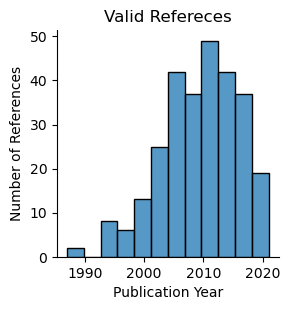

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.displot(
    data=number_of_references_df.loc[~number_of_references_df.DOI.isna()],
    x='Year_',
    height=3,
)
plt.title('Valid Refereces')
plt.ylabel('Number of References')
plt.xlabel('Publication Year')
plt.show()

In [69]:
number_of_references_df.DOI.value_counts()

DOI
https://doi.org/10.1371/journal.pgen.0030231          1
https://doi.org/10.1073/pnas.0403010101               1
https://doi.org/10.1073/pnas.0708608105               1
https://doi.org/10.1073/pnas.0807043105               1
https://doi.org/10.1073/pnas.1120312109               1
                                                     ..
https://doi.org/10.1261/rna.2509811                   1
https://doi.org/10.1261/rna.2670811                   1
https://doi.org/10.1371/journal.pgen.1002815          1
https://doi.org/10.1371/journal.pgen.1005571          1
https://doi.org/10.1002/j.1460-2075.1993.tb05652.x    1
Name: count, Length: 298, dtype: int64

In [70]:
number_of_references_df.head(2)['Example full reference'].unique()

array(['Kettler GC, et al. (2007) Patterns and Implications of Gene Gain and Loss in the Evolution of Prochlorococcus. PLoS Genetics, 3(12):e231.',
       'Dufresne, A., et al. (2003). Genome sequence of the cyanobacterium Prochlorococcus marinus SS120, a nearly minimal oxyphototrophic genome. PNAS, 100(17): 10020-10025.'],
      dtype=object)

In [71]:
non_unique_titles = number_of_references_df.loc[number_of_references_df.DOI.isna()].groupby(['First Author']).Title.agg(['unique', 'nunique'])
non_unique_titles.loc[non_unique_titles['nunique']>1].sort_values('nunique', ascending=False)
with pd.option_context('display.max_colwidth', None):
    display(non_unique_titles.loc[non_unique_titles['nunique']>1].sort_values('nunique', ascending=False))


,unique,nunique
First Author,,
Wang,"[Metabolic dependencies in marine bacteria revealed through experimental validation, Microbial vitamin B biosynthesis and overconsumption in a globally abundant ocean bacterium, Photosynthetic regulation under salt stress and salt-tolerance mechanism of sweet sorghum, Regulation of photosynthetic pigment biosynthesis in cyanobacteria, Structural and functional analysis of the ubiquinone biosynthesis enzyme UbiE, Structure of the F-type ATP synthase supercomplex in cyanobacteria, Temporal and spatial variations in photosynthetic capacity of Prochlorococcus, Tetrapyrrole biosynthesis in Prochlorococcus, The MEP pathway in Prochlorococcus: Functional analysis and evolution, Adaptation mechanisms of the photosynthetic apparatus to light intensity in Prochlorococcus, Iron stress responses in Prochlorococcus, Metabolic Adaptations in Marine Cyanobacteria, Metabolic adaptations in marine photosynthetic bacteria, Temperature adaptation mechanism of marine cyanobacteria, Comparative genomic analysis of MEP pathway genes in Prochlorococcus, Comparative analysis of the MEP pathway in marine cyanobacteria, Redox control of photosystem I by phylloquinone in cyanobacteria, Conservation between higher plants and the moss Physcomitrella patens in response to the phytohormone abscisic acid: a proteomics analysis, Environmental stress responses in marine cyanobacteria, Plastoquinone biosynthesis in cyanobacteria, Structural and Functional Evolution of Tetrapyrrole Biosynthesis Pathway Genes in Plants and Photosynthetic Organisms, Structural and functional insights into the assembly of the NDH-1 complex, Structural basis for the adaptation and function of chlorophyll f in photosystem I, Structural insights into the regulatory mechanism of the chlorophyll biosynthetic pathway, Structure and mechanism of the NDH-1 complex from Thermus thermophilus, Temperature adaptation through membrane lipid remodeling in marine Synechococcus and Prochlorococcus, Organization of the bacterial chromosome by a condensin complex, Adaptation mechanisms of the oligotrophic marine bacterium Prochlorococcus to nitrogen stress, Structure and mechanism of bacterial UMP kinases, Comparative analysis of nucleotide metabolism in marine cyanobacteria, Expansion of Prochlorococcus Meta-metabolomes Using Integrated Genomics and Metabolomics, Genome streamlining in marine prokaryotes: Patterns, regulations and ecological implications, Genome-wide identification of essential proteins in prokaryotes reveals key factors in bacterial cell viability, Metabolic dependencies govern microbial syntrophies during methanogenesis in an anaerobic digestion ecosystem, Metabolic modeling of cell growth and product formation in Prochlorococcus marinus, Metabolic pathway optimization for enhanced production of 5-aminolevulinic acid in Prochlorococcus strains, Streamlined purine metabolism in the globally important marine prokaryotes, Streamlining of the essential amino acid biosynthesis pathway in marine cyanobacteria, Stress response systems in Prochlorococcus, Structural basis for UDP-N-acetylglucosamine acylation by LpxC: A surfactant-resistant antibiotic target, Lipopolysaccharide biosynthesis in marine cyanobacteria: Novel insights from comparative genomics, Comparative genomic analysis of menaquinone biosynthesis in marine bacteria, Evolution of geranylgeranyl reductases: A key enzyme in chlorophyll biosynthesis, Membrane protein insertion pathways in cyanobacteria, Adaptation to nutrient stress in Prochlorococcus strains isolated from diverse marine environments, Condensin promotes the juxtaposition of DNA flanking its loading site in Bacillus subtilis, Diversity and evolution of metabolic pathways in marine picocyanobacteria, Metabolic pathway analysis in Prochlorococcus marinus, Oceanic vitamin B2 cycling: insights from environmental genomics, Structural and Functional Studies of LpxA from Marine Cyanobacteria, The cell wall structure of cyanobacter

# Uptake

In [72]:
uptake_series = df_database.loc[df_database.section_name.isin(['uptake']), 'section_content']


In [73]:
uptake_series.value_counts()

section_content
No direct evidence for involvement in uptake processes.\n                                129
No direct evidence for involvement in uptake processes\n                                  61
No direct role in uptake processes identified\n                                           46
No direct role in uptake processes identified.\n                                          39
No specific information available about uptake processes.\n                               18
                                                                                        ... 
No direct role in uptake processes\n                                                       1
Works in conjunction with glucose transporters to facilitate glucose utilization.\n        1
No direct evidence for uptake processes related to folB.\n                                 1
No direct evidence for tryptophan uptake regulation\n                                      1
Facilitates phosphate storage when external concentrat

In [74]:
uptake_df = df_database.loc[
    df_database.section_name.isin(['uptake']) & 
    ~df_database.section_content.str.startswith('No direct evidence') & 
    ~df_database.section_content.str.startswith('No direct role') &
    ~df_database.section_content.str.startswith('No direct involvement in uptake processes') &
    ~df_database.section_content.str.startswith('No specific information available about uptake') &
    ~df_database.section_content.str.startswith('No specific data available on uptake processes') &
    ~df_database.section_content.str.startswith('No direct information available on uptake pro') &
    ~df_database.section_content.str.startswith('No direct information available about uptake') & 
    ~df_database.section_content.str.startswith('No specific data available regarding uptake')  &
    ~df_database.section_content.str.startswith('No specific information available for uptake') &
    ~df_database.section_content.str.startswith('Information not available for specific uptake processes') &
    ~df_database.section_content.str.startswith('No specific information available') &
    ~df_database.section_content.str.startswith('Insufficient data available on specific uptake processes') &
    ~df_database.section_content.str.startswith('Insufficient data available for specific uptake') &
    ~df_database.section_content.str.startswith('[No direct role in uptake processes identified]') 

  
]


In [75]:
with pd.option_context('display.max_colwidth', None):
    display(uptake_df[['gene', 'section_content', 'Conservation', 'citations']].style.set_properties(**{'text-align': 'left'}))    

,gene,section_content,Conservation,citations
37,queG,"Requires cobalamin as cofactor, suggesting dependence on external vitamin B12 sources.",Likely conserved across Prochlorococcus strains due to general B12 auxotrophy.,
502,ndhI,Critical component of the CO2 uptake system through NDH-1 complex activity,"Conserved mechanism but with strain-specific variations in efficiency [Wang et al., 2016]","[Wang et al., 2016]"
810,sat,Facilitates sulfate uptake through activation of sulfate for subsequent metabolism,"Mechanism conserved across cyanobacteria [Casey et al., 2009]","[Casey et al., 2009]"
888,ntcA,Regulates expression of nitrogen transport systems including ammonium and urea transporters,"Core transport systems are conserved but with strain-specific variations [Berube, 2015].","[Berube, 2015]"
978,amt,"AMT facilitates high-affinity NH4+ transport with Km values in the nanomolar range [García-Fernández, 2004].","Transport kinetics are conserved but show some strain-specific optimization [Martiny, 2009].","[García-Fernández, 2004], [Martiny, 2009]"
1225,pip,"May be involved in the processing of external peptides for nitrogen acquisition, though direct evidence is limited.","Similar roles observed in other marine bacteria, but specific conservation patterns unknown.",
1246,ntrB,Facilitates active transport of nitrate across cell membrane as part of ABC transporter complex,Function conserved in strains with complete nitrate transport systems.,
1257,cynS,"Cyanate uptake mechanisms are linked to cynS expression, though specific transporters are not fully characterized.",Data insufficient to determine conservation status of uptake mechanisms.,
1617,larC,"May be involved in nickel utilization pathways, but specific mechanisms not characterized in Prochlorococcus.",Information not available.,
1924,glk,Works in conjunction with glucose transporters to facilitate glucose utilization.,Mechanism conserved across strains but efficiency varies.,


In [76]:
uptake_df.shape

(37, 5)

# Exudation

In [77]:
exudation_series = df_database.loc[df_database.section_name.isin(['exudation']), 'section_content']


In [78]:
exudation_series.value_counts()

section_content
No direct evidence for involvement in exudation processes.\n                        73
No known role in exudation processes.\n                                             36
No direct role in exudation processes identified\n                                  33
No documented role in exudation processes.\n                                        32
No direct role in exudation processes identified.\n                                 31
                                                                                    ..
Active efflux of chromate ions across cell membrane\n                                1
No specific information available about exudation processes related to aroB.\n       1
No known exudation processes associated with nadA.\n                                 1
No specific data available on exudation processes\n                                  1
No direct evidence for role in phosphate exudation\n                                 1
Name: count, Length: 123, d

In [79]:
exudation_df = df_database.loc[
    df_database.section_name.isin(['exudation']) & 
    ~df_database.section_content.str.startswith('No direct evidence') & 
    ~df_database.section_content.str.startswith('No direct role') &
    ~df_database.section_content.str.startswith('No known role') &
    ~df_database.section_content.str.startswith('No specific data available') &
    ~df_database.section_content.str.startswith('No specific information available') &
    ~df_database.section_content.str.startswith('No documented role') &
    ~df_database.section_content.str.startswith('No known exudation processes') &
    ~df_database.section_content.str.startswith('Insufficient data available regarding exudation processes') &
    ~df_database.section_content.str.startswith('No known direct role') &
    ~df_database.section_content.str.startswith('Insufficient data available') &
    ~df_database.section_content.str.startswith('No known direct role ') &
    ~df_database.section_content.str.startswith('Limited data available on ') &
    ~df_database.section_content.str.startswith('No documented exudation processes') &
    ~df_database.section_content.str.startswith('No documented') &
    ~df_database.section_content.str.startswith('No information available') &
    ~df_database.section_content.str.startswith('No information available regarding exudation processes') &
    ~df_database.section_content.str.startswith('No direct involvement in ') &
    ~df_database.section_content.str.startswith('No specific information available about') &
    ~df_database.section_content.str.startswith('No specific data available on') &
    ~df_database.section_content.str.startswith('No direct information available on') &
    ~df_database.section_content.str.startswith('No direct information available about') & 
    ~df_database.section_content.str.startswith('No specific data available regarding ')  &
    ~df_database.section_content.str.startswith('No specific information available for ') &
    ~df_database.section_content.str.startswith('Information not available for specific ') &
    ~df_database.section_content.str.startswith('No specific information available') &
    ~df_database.section_content.str.startswith('Insufficient data available on specific ') &
    ~df_database.section_content.str.startswith('Insufficient data available for specific') &
    ~df_database.section_content.str.startswith('[No direct role in exudation processes') 

  
]


In [80]:
exudation_df.shape

(27, 5)

In [81]:
with pd.option_context('display.max_colwidth', None):
    display(exudation_df[['gene', 'section_content']].style.set_properties(**{'text-align': 'left'}))

,gene,section_content
1574,rplS,"Protein has been detected in membrane vesicles [Biller et al., 2014]."
1695,lepB,"Involved in processing of secreted proteins, though specific substrates in Prochlorococcus are not well-characterized."
2173,chrA,Active efflux of chromate ions across cell membrane
2184,arsJ,Facilitates export of arsenical compounds through MFS transport mechanism
2195,arsB,Active efflux of arsenite compounds
2364,lptB,Indirect role in membrane vesicle formation and release
2659,lptC,"May influence exudation through membrane organization, but direct evidence lacking."
2844,rpmB,"Present in membrane vesicles, suggesting potential role in intercellular communication [Biller et al., 2014]."
2951,secF,"Involved in protein secretion pathway, though specific secreted proteins not well characterized in Prochlorococcus"
2962,secD,"Involved in protein secretion pathway, though specific secreted proteins in Prochlorococcus are not well characterized."


# Stress response

In [82]:
stress_responses_series = df_database.loc[df_database.section_name.isin(['stress_responses']), 'section_content']


In [83]:
stress_responses_series.value_counts()


section_content
Limited data available on specific stress responses.\n                                                                      19
Data not available for other stress responses.\n                                                                             7
Upregulation under nitrogen limitation conditions\n                                                                          6
Limited direct evidence for specific stress responses.\n                                                                     5
No specific data available for other stress responses.\n                                                                     5
                                                                                                                            ..
DnaA expression and activity are modulated under nutrient stress conditions, contributing to growth rate regulation.\n       1
Temperature stress affects DnaA-dependent replication initiation efficiency.\n                 

In [84]:
stress_responses_df = df_database.loc[
    df_database.section_name.isin(['stress_responses']) & 
    ~df_database.section_content.str.startswith('Limited data available') & 
    ~df_database.section_content.str.startswith('No direct studies available') & 
    ~df_database.section_content.str.startswith('No specific data available') & 
    ~df_database.section_content.str.startswith('Limited data available') & 
    ~df_database.section_content.str.startswith('Limited direct evidence') & 
    ~df_database.section_content.str.startswith('Limited direct evidence') & 
    ~df_database.section_content.str.startswith('Data not available') &
    ~df_database.section_content.str.startswith('Insufficient data available ') &
    ~df_database.section_content.str.startswith('Limited direct data available') &
    ~df_database.section_content.str.startswith('No direct experimental evidence') &
    ~df_database.section_content.str.startswith('No direct evidence') & 
    ~df_database.section_content.str.startswith('No specific stress response data available for') &
    ~df_database.section_content.str.startswith('Insufficient direct experimental data available') &
    ~df_database.section_content.str.startswith('Data on other stress responses is limited') &
    ~df_database.section_content.str.startswith('Data on specific stress responses is limited') &
    ~df_database.section_content.str.startswith('No direct studies on stress response roles for') &
    ~df_database.section_content.str.startswith('No direct experimental data available for') &
    ~df_database.section_content.str.startswith('[Information not available for additional stress responses]') &
 
    ~df_database.section_content.str.startswith('No documented direct involvement in other stress responses') &
    ~df_database.section_content.str.startswith('Data on other stress responses not available') &
    ~df_database.section_content.str.startswith('Data on specific stress responses is limited ') 
].copy()


In [85]:
for i in ['limitation', 'stress']:
    stress_responses_df[i] = stress_responses_df.section_content.str.extract(r'\b(\w+\s+' + i+')', flags=re.IGNORECASE)

In [86]:
remove_stresses = ['on stress',           
'of stress',
'in stress',
'during stress',
'Specific stress']
stress_responses_df.loc[stress_responses_df.stress.isin(remove_stresses), 'stress'] = np.NaN

In [87]:
for i in ['limitation', 'stress']:
    display(stress_responses_df[i].value_counts())


limitation
nitrogen limitation      43
nutrient limitation      31
phosphate limitation     11
iron limitation           8
sulfur limitation         5
Nitrogen limitation       4
Nutrient limitation       3
B12 limitation            2
carbon limitation         2
phosphorus limitation     2
folate limitation         1
selenium limitation       1
CO2 limitation            1
Phosphorus limitation     1
copper limitation         1
cobalt limitation         1
Iron limitation           1
Name: count, dtype: int64

stress
oxidative stress         99
light stress             54
temperature stress       51
osmotic stress           28
nitrogen stress          26
nutrient stress          23
Oxidative stress         21
general stress           15
Temperature stress       14
Light stress             14
phosphate stress          8
UV stress                 7
Oxidative Stress          7
environmental stress      7
metal stress              5
thermal stress            5
carbon stress             4
under stress              4
Osmotic stress            4
iron stress               3
cold stress               3
limitation stress         3
Salt stress               2
heat stress               2
photooxidative stress     2
various stress            2
Cold stress               2
Metal stress              2
processing stress         1
folding stress            1
specific stress           1
Temperature Stress        1
availability stress       1
pH stress                 1
Envelope stress           1
cellular stre

In [88]:
stress_responses_df['Stress/Limitation'] = stress_responses_df[['limitation', 'stress']].apply(lambda x: ', '.join(x.dropna()), axis=1)

In [89]:
#stress_responses_df[['Stress/Limitation']].value_counts(dropna=False).to_csv('stresses.csv')
stress_map = pd.read_csv('map_stress_values.csv')
stress_map

,Stress/Limitation,Stress,Stress Category
0,NaN,Unclear,Unclear
1,oxidative stress,Oxidative,Env
2,light stress,High-light,Env
3,temperature stress,Temperature,Thermal
4,nitrogen limitation,Nitrogen,Nutrients
...,...,...,...
66,membrane stress,Unclear,Unclear
67,copper limitation,Copper,Trace Metals
68,folate limitation,Folate,Vitamin
69,"iron limitation, under stress",Iron,Nutrients


In [90]:
stress_responses_df.columns, stress_map.columns

(Index(['gene', 'section_name', 'section_content', 'citations', 'Conservation',
        'limitation', 'stress', 'Stress/Limitation'],
       dtype='object'),
 Index(['Stress/Limitation', 'Stress', 'Stress Category'], dtype='object'))

In [91]:
stress_responses_df = pd.merge(stress_responses_df, stress_map, on='Stress/Limitation', how='left')
stress_responses_df['Stress'] = stress_responses_df['Stress'].fillna('Unclear')
stress_responses_df['Stress Category'] = stress_responses_df['Stress Category'].fillna('Unclear')
stress_responses_df

,gene,section_name,section_content,citations,Conservation,limitation,stress,Stress/Limitation,Stress,Stress Category
0,dnaN,stress_responses,May be involved in DNA damage response pathway...,,Likely conserved but requires experimental val...,NaN,NaN,,Unclear,Unclear
1,purL,stress_responses,Nitrogen limitation leads to increased purL ex...,,Response pattern observed across multiple stra...,Nitrogen limitation,NaN,Nitrogen limitation,Nitrogen,Nutrients
2,purF,stress_responses,Expression levels show moderate increase under...,"[Casey et al., 2016]",Response appears conserved across high-light a...,nitrogen limitation,NaN,nitrogen limitation,Nitrogen,Nutrients
3,queG,stress_responses,May be involved in translation optimization un...,,Response pattern unknown in Prochlorococcus sp...,NaN,nutrient stress,nutrient stress,Nutrient,Nutrients
4,queG,stress_responses,Potential role in maintaining translation fide...,,Insufficient data for conservation assessment ...,NaN,NaN,,Unclear,Unclear
...,...,...,...,...,...,...,...,...,...,...
691,mraY,stress_responses,Involved in cell wall remodeling during osmoti...,,Limited data available on conservation of stre...,NaN,osmotic stress,osmotic stress,Osmotic,Env
692,mraY,stress_responses,May participate in cell wall modifications dur...,,Information not available on conservation acro...,NaN,temperature stress,temperature stress,Temperature,Thermal
693,uvrA,stress_responses,UV Radiation Response: UvrA expression increas...,,"Conserved response across all studied strains,...",NaN,NaN,,Unclear,Unclear
694,uvrA,stress_responses,Oxidative Stress Response: Limited evidence su...,,Insufficient data to confirm conservation status,NaN,Oxidative Stress,Oxidative Stress,Oxidative,Env


In [92]:
stress_responses_df.shape, stress_responses_df.gene.nunique()

((696, 10), 405)

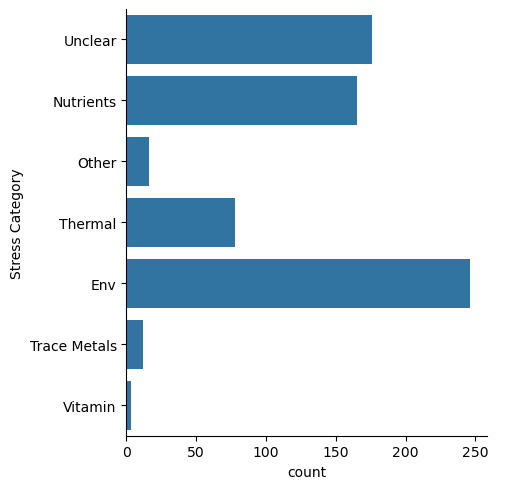

In [93]:
sns.catplot(
    data=stress_responses_df, y='Stress Category', kind='count'
)
    #stress_responses_df.Stress.value_counts()

In [94]:
stress_responses_df.groupby(['Stress Category', 'Stress'])['gene'].nunique(). reset_index()


,Stress Category,Stress,gene
0,Env,Environmental,7
1,Env,High-light,68
2,Env,Osmotic,32
3,Env,Oxidative,126
4,Env,Photooxidative,2
5,Env,Salt,2
6,Env,UV,7
7,Env,pH,1
8,Nutrients,CO2,1
9,Nutrients,Carbon,6


# coculture

In [95]:
coculture_role_series = df_database.loc[df_database.section_name.isin(['coculture_role']), 'section_content']


In [96]:
coculture_role_series.value_counts()

section_content
Limited data available on expression changes in coculture conditions.\n                                                         12
No specific studies available on expression changes in coculture conditions.\n                                                   4
Insufficient data available on specific role during coculture conditions\n                                                       3
Insufficient data available regarding specific expression changes or functional modifications in coculture conditions.\n         2
No direct evidence available regarding role in coculture conditions.\n                                                           2
                                                                                                                                ..
No specific studies available on gloB expression or function in coculture conditions.\n                                          1
No specific studies examining bchL expression or regulation in cocu

In [97]:
coculture_role_df = df_database.loc[
    df_database.section_name.isin(['coculture_role']) & 
    ~df_database.section_content.str.startswith('Limited data available on expression changes in coculture conditions') & 
    ~df_database.section_content.str.startswith('Limited direct evidence ') &
    ~df_database.section_content.str.startswith('Insufficient data available ') &
    ~df_database.section_content.str.startswith('No specific data available') &
    ~df_database.section_content.str.startswith('No specific studies available ') &
    ~df_database.section_content.str.startswith('No direct studies available ') &
    ~df_database.section_content.str.startswith('No specific studies ') &
    ~df_database.section_content.str.startswith('No studies have directly examined ') &
    ~df_database.section_content.str.startswith('No significant changes ') &
    ~df_database.section_content.str.startswith('Limited data available on ') &
    ~df_database.section_content.str.startswith('Limited direct research on ') &
     ~df_database.section_content.str.startswith('Limited direct studies on ') &
     ~df_database.section_content.str.startswith('No direct evidence available') &
     ~df_database.section_content.str.startswith('No direct studies of ') &
     ~df_database.section_content.str.startswith('No specific information available ') &
     ~df_database.section_content.str.startswith('No studies available ') &
     ~df_database.section_content.str.startswith('No direct studies on ') &
     ~df_database.section_content.str.startswith('No published research available ') &
     ~df_database.section_content.str.startswith('No direct experimental evidence available ') &
     ~df_database.section_content.str.startswith('Limited direct studies available ') &
     ~df_database.section_content.str.startswith('Limited direct information available') &
     ~df_database.section_content.str.contains('not available in current literature')  &
     ~df_database.section_content.str.startswith('No direct evidence for specific role ') &
     ~df_database.section_content.str.startswith('[No specific information available ') 
    # ~df_database.section_content.str.startswith('No specific information available') &
    # ~df_database.section_content.str.startswith('Insufficient data available on specific ') &
    # ~df_database.section_content.str.startswith('Insufficient data available for specific') 

  
]


In [98]:
coculture_role_df.shape

(17, 5)

In [99]:
with pd.option_context('display.max_colwidth', None):
    display(coculture_role_df[['gene', 'section_content']].style.set_properties(**{'text-align': 'left'}))

,gene,section_content
208,cbiD,"While specific coculture studies focusing on cbiD are limited, the gene's role in B12 synthesis suggests it may influence interactions with B12-dependent heterotrophic bacteria."
1442,coxB,"Expression levels of coxB show moderate changes in coculture with heterotrophic bacteria, suggesting potential adaptation of respiratory metabolism in response to bacterial presence [Casey, 2016]."
1453,groL,"Expression levels of groL show moderate increases when Prochlorococcus is grown in coculture with heterotrophic bacteria, particularly under oxidative stress conditions [Morris et al., 2010]."
1872,petE,"Limited data available. Some evidence suggests modified expression patterns in presence of heterotrophic bacteria [Morris et al., 2012]."
2046,acs,"Limited direct studies available. Some evidence suggests increased expression in presence of heterotrophic bacteria, possibly related to acetate availability in coculture conditions."
2108,nrdJ,"Expression of nrdJ may be influenced by the presence of B12-producing heterotrophic bacteria, though direct studies are limited."
2715,metH,Expression levels increase in coculture with B12-producing heterotrophic bacteria. Forms part of the molecular basis for bacterial-algal symbiosis in marine environments.
2823,dnaK,"Expression levels change during coculture with heterotrophic bacteria, particularly under oxidative stress conditions [Morris et al., 2010]."
3096,ureE,"Expression levels increase in coculture with heterotrophic bacteria, suggesting enhanced urea utilization in mixed communities [Christie-Oleza et al., 2017]"
3118,urtA,"Expression levels change in response to heterotrophic bacterial presence, suggesting integration in bacterial community interactions. Studies indicate potential upregulation when cocultured with specific heterotrophic bacteria that may provide urea through degradation of organic matter."


# Build gradio app

In [100]:
number_of_references_df.columns

Index(['First Author', 'Year', 'Title', 'DOI', 'Number_of_Genes',
       'Example gene', 'Example Authors', 'Example Journal', 'Example Pages',
       'Example full reference', 'ref', 'Year_'],
      dtype='object')

In [101]:
number_of_references_df['Example Journal'].value_counts().to_dict()

{'PNAS': 61,
 'Nature': 58,
 'Environmental Microbiology': 52,
 'Nature Microbiology': 42,
 'Science': 36,
 'Journal of Bacteriology': 35,
 'ISME Journal': 33,
 'ISME J': 31,
 'Nature Reviews Microbiology': 22,
 'J Bacteriol': 15,
 'Molecular Microbiology': 13,
 'Journal of Biological Chemistry': 13,
 'Molecular Biology and Evolution': 12,
 'Marine Genomics': 11,
 'PCC': 11,
 'Nature Communications': 11,
 'RNA': 11,
 'J Biol Chem': 10,
 'Nature Chemical Biology': 10,
 'Scientific Reports': 9,
 'Proc Natl Acad Sci USA': 9,
 'Frontiers in Microbiology': 9,
 'Cell': 9,
 'Environ Microbiol': 9,
 'Nucleic Acids Research': 8,
 'EMBO J': 7,
 'Annual Review of Biochemistry': 6,
 'RNA Biology': 6,
 'Biochemistry': 6,
 'Molecular Cell': 6,
 'Marine Biology': 6,
 'Journal of Molecular Biology': 5,
 'Annual Review of Microbiology': 5,
 'Nature Reviews Molecular Cell Biology': 5,
 'Plant Physiology': 5,
 'Annual Review of Marine Science': 5,
 'Nature Plants': 5,
 'Biochemical Society Transactions':

In [108]:
reference_df.columns

Index(['gene', 'section_content', 'Authors', 'Year', 'Title', 'Journal_pages',
       'Journal', 'Pages', 'First Author', 'First Author lower', 'Title lower',
       'crossref reference', 'crossref DOI'],
      dtype='object')

In [109]:
database_cols_to_display = ['gene', 'section_content',  'Conservation', 'citations',]
reference_cols_to_display = ['Example full reference', 'DOI', 'Number_of_Genes', 'First Author', 'Year', 'Title','Example Journal', ]
reference_ungrouped_cols_to_display = ['gene', 'section_content', 'crossref DOI', 'First Author', 'Year', 'Journal',    ]
df_to_display_genes = gff_named_df[['gene', 'product']]
df_to_display_coculture = coculture_role_df[database_cols_to_display]
df_to_display_exudation = exudation_df[database_cols_to_display]
df_to_display_uptake = uptake_df[database_cols_to_display]
df_to_display_stress = stress_responses_df[database_cols_to_display+ ['Stress Category', 'Stress', ]] 
df_to_display_reference = number_of_references_df[reference_cols_to_display].copy()
df_to_display_reference_ungrouped = reference_df[reference_ungrouped_cols_to_display].copy()
#df_to_display_reference['Number of Papers'] = 1
df_to_display_reference['Has DOI'] = df_to_display_reference['DOI'].isna().map({True:'No DOI', False: 'Has DOI'})
df_to_display_reference_ungrouped['Has DOI'] = df_to_display_reference_ungrouped['crossref DOI'].isna().map({True:'No DOI', False: 'Has DOI'})

In [110]:
import gradio as gr

df_to_display = gff_named_df[['gene', 'product']]
def filter_records(df, query):
    mask = np.column_stack([df[col].astype(str).str.contains(query, na=False, regex=False, case=False) for col in df])
    filtered_df = df.loc[mask.any(axis=1)]
    return filtered_df

def get_top_10(df, column, aggfunc):
    top_10_df = df.groupby(column)['Number_of_Genes'].agg('count').reset_index().nlargest(10, 'Number_of_Genes')
    return df.loc[df[column].isin(top_10_df[column])]
    
def filter_records_reference(df, query, hasdoi):
    hasdoi_map = {"All" : ['Has DOI', 'No DOI'], "Valid (with DOI)" : ['Has DOI'], "Invalid (no DOI)" : ['No DOI']}
    tmpdf = df.loc[df['Has DOI'].isin(hasdoi_map[hasdoi]) ]
    tmpdf = filter_records(tmpdf, query)
    return [tmpdf] * 2 + [get_top_10(tmpdf, 'First Author', 'count'), get_top_10(tmpdf, 'Example Journal', 'count')]

def filter_records_reference_ungrouped(df, query, hasdoi):
    hasdoi_map = {"All" : ['Has DOI', 'No DOI'], "Valid (with DOI)" : ['Has DOI'], "Invalid (no DOI)" : ['No DOI']}
    tmpdf = df.loc[df['Has DOI'].isin(hasdoi_map[hasdoi]) ]
    tmpdf = filter_records(tmpdf, query)
    return tmpdf

def gene_desc2text(gene):
    row_select = df_to_display.loc[df_to_display['gene'].isin([gene])].squeeze()
    return f'# {row_select["gene"]}:    {row_select["product"]}\n'

def on_select(evt: gr.SelectData):
    #  'col_value', 'index', 'row_value', 'selected', 'target', 'value']
    return evt.row_value[0]


In [111]:
gene_desc2text(gene)

'# dnaN:    DNA polymerase III subunit beta\n'

In [112]:
def get_gene_db_results(gene):
    desc = gene_desc2text(gene)
    
    literature_review, database_entry = parse_database_batch_message(gene)
    return desc, literature_review2text(literature_review), database_entry2text(database_entry)

In [115]:
with gr.Blocks() as demo:

    ### Gene DB
    output_gene_desc = gr.Markdown()
    with gr.Row(equal_height=True):        
        with gr.Tab("Database Entry"):
            output_database_entry = gr.Markdown(label="Database Entry", container=True, show_label=True, show_copy_button=True)
        with gr.Tab("Literature Review"):
            output_lit_review = gr.Markdown(label="Literature Review", container=True, show_label=True, show_copy_button=True)
    with gr.Row():
        genename = gr.Textbox(label="Gene Name")
        genename.submit(fn=get_gene_db_results, inputs=genename, outputs=[output_gene_desc,output_lit_review, output_database_entry], api_name="Gene DB")
        submit_btn = gr.Button("Submit")
    examples = gr.Examples(
        examples=sorted(list(batch_result_dict.keys())), inputs=genename, examples_per_page=50)


    
    with gr.Accordion("Additional Info", open=True, ):

        # Gene Table
        with gr.Tab("List of Available Genes"):
            gene_filter_textbox =  gr.Textbox(label="Filter")
            
            gene_dataframe = gr.Dataframe(df_to_display_genes, max_height=700, wrap=True, )
            gene_dataframe.select(on_select, outputs=genename)
            gene_filter_textbox.submit(fn=lambda x: filter_records(df_to_display_genes, x), inputs=gene_filter_textbox, outputs=gene_dataframe)

        
        # Coculture
        with gr.Tab("Role in Cucultures"):
            coculture_filter_textbox =  gr.Textbox(label="Filter")
            
            coculture_dataframe = gr.Dataframe(df_to_display_coculture, max_height=700, wrap=True,)
            coculture_dataframe.select(on_select, outputs=genename)
            coculture_filter_textbox.submit(fn=lambda x: filter_records(df_to_display_coculture, x), inputs=coculture_filter_textbox, outputs=coculture_dataframe)


        # Uptake
        with gr.Tab("Uptake"):
            uptake_filter_textbox =  gr.Textbox(label="Filter")
            
            uptake_dataframe = gr.Dataframe(df_to_display_uptake, max_height=700, wrap=True,)
            uptake_dataframe.select(on_select, outputs=genename)
            uptake_filter_textbox.submit(fn=lambda x: filter_records(df_to_display_uptake, x), inputs=uptake_filter_textbox, outputs=uptake_dataframe)


        #Exudation
        with gr.Tab("Exudation"):
            exudation_filter_textbox =  gr.Textbox(label="Filter")
            
            exudation_dataframe = gr.Dataframe(df_to_display_exudation, max_height=700, wrap=True,)
            exudation_dataframe.select(on_select, outputs=genename)
            exudation_filter_textbox.submit(fn=lambda x: filter_records(df_to_display_exudation, x), inputs=exudation_filter_textbox, outputs=exudation_dataframe)


        # Stress
        with gr.Tab("Stress"):
            stress_filter_textbox =  gr.Textbox(label="Filter")
            
            stress_plot = gr.BarPlot(
                df_to_display_stress, x="Stress Category", y="gene", 
                y_title="Number of Genes",  sort='y', color='Stress', y_aggregate="count") 
            stress_dataframe = gr.Dataframe(df_to_display_stress, max_height=700, wrap=True,)
            stress_dataframe.select(on_select, outputs=genename)
            stress_filter_textbox.submit(fn=lambda x: [filter_records(df_to_display_stress, x)] * 2, inputs=stress_filter_textbox, outputs=[stress_dataframe, stress_plot])


        # References
        with gr.Tab("References"):
            with gr.Row():
                reference_ungrouped_filter_textbox =  gr.Textbox(label="Filter")
                has_doi_ungrouped_select = gr.Dropdown(["All", "Valid (with DOI)", "Invalid (no DOI)"], value="All", label="Valid References")
            reference_ungrouped_dataframe = gr.Dataframe(df_to_display_reference_ungrouped, max_height=700, wrap=True,) # [reference_cols_to_display]
            #reference_dataframe.select(on_select, outputs=genename)
            reference_ungrouped_onselect_kwarg = dict(fn=lambda query, hasdoi: filter_records_reference_ungrouped(df_to_display_reference_ungrouped, query, hasdoi), inputs=[reference_ungrouped_filter_textbox, has_doi_ungrouped_select], outputs=[reference_ungrouped_dataframe])
            reference_ungrouped_filter_textbox.submit(**reference_ungrouped_onselect_kwarg)
            has_doi_ungrouped_select.input(**reference_ungrouped_onselect_kwarg)

        # References
        with gr.Tab("References Grouped"):
            with gr.Row():
                reference_filter_textbox =  gr.Textbox(label="Filter")
                has_doi_select = gr.Dropdown(["All", "Valid (with DOI)", "Invalid (no DOI)"], value="All", label="Valid References")
                stat_select = gr.Radio(["Number of citations", "Number of papers"], value="Number of papers", label="Summary Statistic")
            with gr.Row(equal_height=True):
                reference_all_by_year = gr.BarPlot(
                    df_to_display_reference, x="Year", y="Number_of_Genes", y_title="Number of Papers", color='Has DOI', x_bin=5, 
                    y_aggregate="count",
                    show_label=True, label='Publication Year', x_label_angle=30)
                reference_all_by_author = gr.BarPlot(
                    get_top_10(df_to_display_reference, 'First Author', 'count'), x="First Author", y="Number_of_Genes", 
                    y_title="Number of Papers", show_label=True, label='Top 10 Authors', sort='y', color='Has DOI', y_aggregate="count", x_label_angle=30) 
                reference_all_by_journal = gr.BarPlot(
                    get_top_10(df_to_display_reference, 'Example Journal', 'count'), x="Example Journal", y="Number_of_Genes", 
                    y_title="Number of Papers", show_label=True, label='Top 10 Journals', sort='y', color='Has DOI', y_aggregate="count", x_label_angle=30) 
                                                  
                
            reference_dataframe = gr.Dataframe(df_to_display_reference, max_height=700, wrap=True,) # [reference_cols_to_display]
            #reference_dataframe.select(on_select, outputs=genename)
            reference_filter_textbox.submit(fn=lambda query, hasdoi: filter_records_reference(df_to_display_reference, query, hasdoi), inputs=[reference_filter_textbox, has_doi_select], outputs=[reference_dataframe, reference_all_by_year,  reference_all_by_author, reference_all_by_journal])
            has_doi_select.input(fn=lambda query, hasdoi: filter_records_reference(df_to_display_reference, query, hasdoi), inputs=[reference_filter_textbox, has_doi_select], outputs=[reference_dataframe, reference_all_by_year,  reference_all_by_author, reference_all_by_journal])
            stat_select_map = {"Number of citations" : 'sum', "Number of papers" : 'count'}
            stat_select.change(lambda y: [gr.BarPlot(y_aggregate=stat_select_map[y], y_label=y)] * 3, stat_select, [reference_all_by_year,  reference_all_by_author, reference_all_by_journal])
    
    submit_btn.click(fn=get_gene_db_results, inputs=genename, outputs=[output_gene_desc,output_lit_review, output_database_entry], api_name="Gene DB")

#demo.launch(share=True)
demo.launch(inbrowser=True)


* Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.


In [116]:
gff_named_df.loc[gff_named_df.gene.isin(['ntcA'])]

,gene_name,gene,locus_tag,product,protein_id
80,"ntcA , TX50_RS01275",ntcA,TX50_RS01275,global nitrogen regulator NtcA,WP_011131884.1
